Training Accuracy: 0.83
Validation Accuracy: 0.82
Test Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

     defects       0.82      1.00      0.90      1194
      normal       1.00      0.00      0.00       265

    accuracy                           0.82      1459
   macro avg       0.91      0.50      0.45      1459
weighted avg       0.85      0.82      0.74      1459



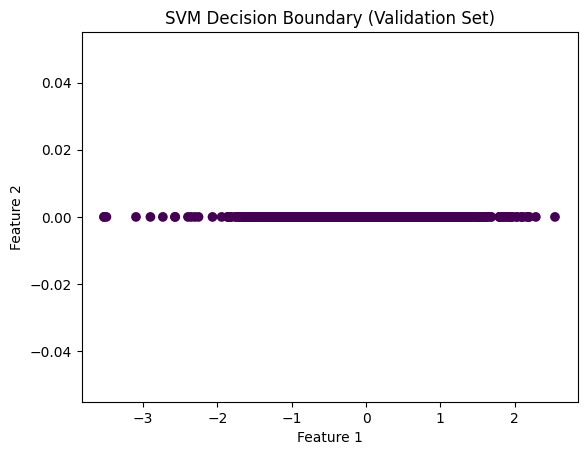

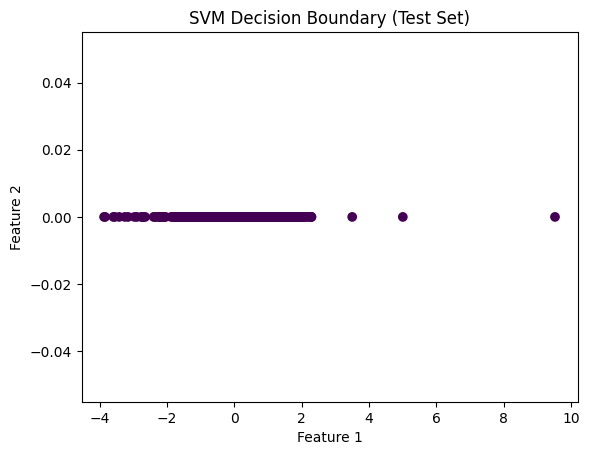

In [1]:
#Importing Libraries:

import numpy as np
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt



# Loading Data

dire = "D:/nlcdata"
categories = ['defects', 'normal']

images = []
labels = []

SIZE = 600

for category in categories:
    path = os.path.join(dire, category)
    label = categories.index(category)
    
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        tree_img = cv2.imread(imgpath, 0)
        try:
            tree_img = cv2.resize(tree_img, (SIZE, SIZE))
            images.append(tree_img)
            labels.append(label)
        except Exception as e:
            pass

images = np.array(images)
labels = np.array(labels)



#Feature Extraction

def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for img in dataset:
        glcm = cv2.calcHist([img.astype(np.uint8)], [0], None, [256], [0, 256])
        contrast = np.sum((np.arange(glcm.shape[0]) - np.arange(glcm.shape[1])) ** 2 * glcm)
        dissimilarity = np.sum(np.abs(np.arange(glcm.shape[0]) - np.arange(glcm.shape[1])) * glcm)
        homogeneity = np.sum(glcm / (1 + np.abs(np.arange(glcm.shape[0]) - np.arange(glcm.shape[1]))))
        energy = np.sum(glcm ** 2)
        
        df = pd.DataFrame({
            'Energy': energy,
            'Diss_sim': dissimilarity,
            'Homogen': homogeneity,
            'Contrast': contrast
        }, index=[0])
        
        image_dataset = pd.concat([image_dataset, df], ignore_index=True)
        
    return image_dataset

X_for_ML = feature_extractor(images)


# Data Splitiing

# Train-test split
xtrain, xtest, ytrain, ytest = train_test_split(X_for_ML, labels, test_size=0.15, random_state=42)

# Further split the data into training and validation sets
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.10, random_state=42)



# Feature scaling
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)
xval_scaled = scaler.transform(xval)  # Scale validation data using the same scaler



# Model Initialization and training
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the model
svm_classifier.fit(xtrain_scaled, ytrain)

# Predictions on validation data
y_pred_val = svm_classifier.predict(xval_scaled)

# Predictions on test data
y_pred_test = svm_classifier.predict(xtest_scaled)



#Model evaluation
# Evaluate accuracy
train_accuracy = accuracy_score(ytrain, svm_classifier.predict(xtrain_scaled))
val_accuracy = accuracy_score(yval, y_pred_val)
test_accuracy = accuracy_score(ytest, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(ytest, y_pred_test, target_names=categories, zero_division=1))


#Visulaization

# Plotting decision boundaries for the validation set
plt.scatter(xval_scaled[:, 0], xval_scaled[:, 1], c=y_pred_val, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary (Validation Set)')
plt.show()

# Plotting decision boundaries for the test set
plt.scatter(xtest_scaled[:, 0], xtest_scaled[:, 1], c=y_pred_test, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary (Test Set)')
plt.show()
